# Soybean Image Classifier Using Neural Network Built From Scratch

The purpose of this project is to build a neural network from scratch using the Numpty library. This excercise helps with understanding the architecture and maths behind the neural network libraries provided by Keras and Tensorflow.

This project uses the Kaggle [Weed Detection In Soybean Crops](https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops/) dataset for training and testing the model.

## Setup

In [ ]:
# Make sure we have all the required modules imported into our environment

import sys
!{sys.executable} -m pip install -U kaggle
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U image
!{sys.executable} -m pip install -U opencv-python
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install -U pandas

## Download & Explore Data

In [2]:
# Get Kaggle Data - Note you must setup Kaggle on your computer using the instructions here: 
# https://github.com/Kaggle/kaggle-api#api-credentials

!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops -p ./Data --unzip

100%|█████████████████████████████████████▉| 2.36G/2.37G [02:49<00:00, 13.4MB/s]
100%|██████████████████████████████████████| 2.37G/2.37G [02:49<00:00, 15.0MB/s]


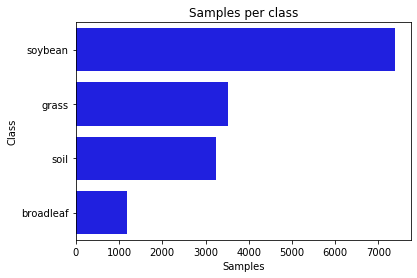

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

DATA_DIR = './Data/dataset/'

# List classes in dataset
ignore = ['.DS_Store', 'dataset']
classes = [folder for folder in os.listdir(DATA_DIR) if folder not in ignore]
# Import Dataset: Sample image paths
def get_class_img_paths(img_class):
    return [DATA_DIR + '{}/'.format(img_class) + img for img in os.listdir(DATA_DIR + img_class) if img not in ignore]

class_img_paths = {}
class_size = {}
for c in classes:
    class_img_paths[c] = get_class_img_paths(c)
    class_size[c] = len(class_img_paths[c])
    
fig = sns.barplot(x = 'val', y = 'cat', data = {'cat': classes, 'val': list(class_size.values())}, color = 'blue')
plt.xlabel("Samples")
plt.ylabel("Class")
plt.title("Samples per class")
plt.show(fig)

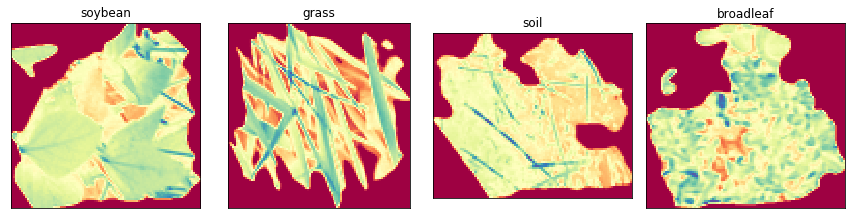

In [2]:
import numpy as np
from PIL import Image

# Display first image of each class
plt.figure(figsize=(3 * len(classes), 3))
col = 1
for c in classes:
    img = Image.open(f'{DATA_DIR}/{c}/1.tif')
    img.thumbnail((96,96))
    pic = np.asarray(img)

    plt.subplot(1,len(classes),col).set_title(c)
    plt.imshow(pic[:, :, 0], cmap='Spectral')
    plt.xticks([])
    plt.yticks([])
    col += 1

plt.tight_layout()

## Pre-Process Data

We need to re-organise the data into training and test datasets.

In [6]:
import cv2
from sklearn.model_selection import train_test_split

INPUT_WIDTH = 200
INPUT_HEIGHT = 200

X = []
Y = []

# Flatten array into X and Y 
for idx, c in enumerate(classes):
    for img_path in class_img_paths[c]:
         
        img = cv2.resize(cv2.imread(img_path), (INPUT_WIDTH, INPUT_HEIGHT))
        X.append(img)
        Y.append(idx)

# Convert to Numpy arrays
X, Y = np.array(X), np.array(Y)

print(f"X shape: {X.shape} | Y shape: {Y.shape}") 

X shape: (15336, 200, 200, 3) | Y shape: (15336,)


In [7]:
# Simple Training / Validation Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
# Clear memory for original X and Y arrays
#del X, Y

# Reshape input X arrays to flatten them
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')

# Get the shapes of each array
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}") 

X_train shape: (12268, 120000) | y_train shape: (12268,)
X_test shape: (3068, 120000) | y_test shape: (3068,)


In [9]:
# We shuffled arrays, but lets see how many of each class we have in our training and test sets

print("Training Set Class Sizes")
unique, counts = np.unique(y_train, return_counts=True)
for c in unique:
    print(f"{c}: {counts[c]}")
    
print("Test Set Class Sizes")
unique, counts = np.unique(y_test, return_counts=True)
for c in unique:
    print(f"{c}: {counts[c]}")

Training Set Class Sizes
0: 5873
1: 2859
2: 2583
3: 953
Test Set Class Sizes
0: 1503
1: 661
2: 666
3: 238


## Build Neural Network With Numpy

In [26]:
# NN Architecture Implementation
# Source: https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/

class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        #DEfine relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N


        #Want to find dW2(dL/dW2)
        # Derivation: dL/dW2 = dL/dscore * dscore/dW2(chain rule)
        #dL/dscore = softmax since L(score) = softmax(variable)
        #dscore/dW2 = relu_(hidden layer output)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        #dL/dW1 = dL/dscore * dscore/drelu(layler1) * drelu(layer1)/dW1 
        #dL/dW1 = dW1 = softmax * W2 * X 
        hidden = softmax.dot(W2.T)

        #derivative of a max gate
        #Intuition: in forward pass if neuron didn't fire that mean. the derivative of that neuron 
        # is 0. This might be bad since this will kill gradient. 
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):
        '''
        Train using SGD 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = int(max(N/batch_size, 1))
        print(f"Iterations Per Epoch: {iteration_per_epoch}")
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [35]:
# Build Simple NN Model with 2 layers

net = TwoLayerNet(X_train.shape[1], 200,len(classes), 1e-3)
stats = net.train(X_train, y_train, X_test, y_test, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, num_iters=5000, 
              batch_size=100, it_verbose = 200,verbose=True)

Iterations Per Epoch: 122
iteration: 0 / 5000 | Loss: 1.483504
iteration: 200 / 5000 | Loss: 0.646293
iteration: 400 / 5000 | Loss: 0.601002
iteration: 600 / 5000 | Loss: 0.500879
iteration: 800 / 5000 | Loss: 0.571069
iteration: 1000 / 5000 | Loss: 0.448975
iteration: 1200 / 5000 | Loss: 0.608821
iteration: 1400 / 5000 | Loss: 0.583807
iteration: 1600 / 5000 | Loss: 0.535074
iteration: 1800 / 5000 | Loss: 0.559411
iteration: 2000 / 5000 | Loss: 0.468154
iteration: 2200 / 5000 | Loss: 0.532596
iteration: 2400 / 5000 | Loss: 0.427018
iteration: 2600 / 5000 | Loss: 0.509378
iteration: 2800 / 5000 | Loss: 0.487170
iteration: 3000 / 5000 | Loss: 0.558921
iteration: 3200 / 5000 | Loss: 0.562087
iteration: 3400 / 5000 | Loss: 0.670162
iteration: 3600 / 5000 | Loss: 0.535062
iteration: 3800 / 5000 | Loss: 0.451952
iteration: 4000 / 5000 | Loss: 0.499582
iteration: 4200 / 5000 | Loss: 0.496951
iteration: 4400 / 5000 | Loss: 0.477179
iteration: 4600 / 5000 | Loss: 0.390800
iteration: 4800 / 500

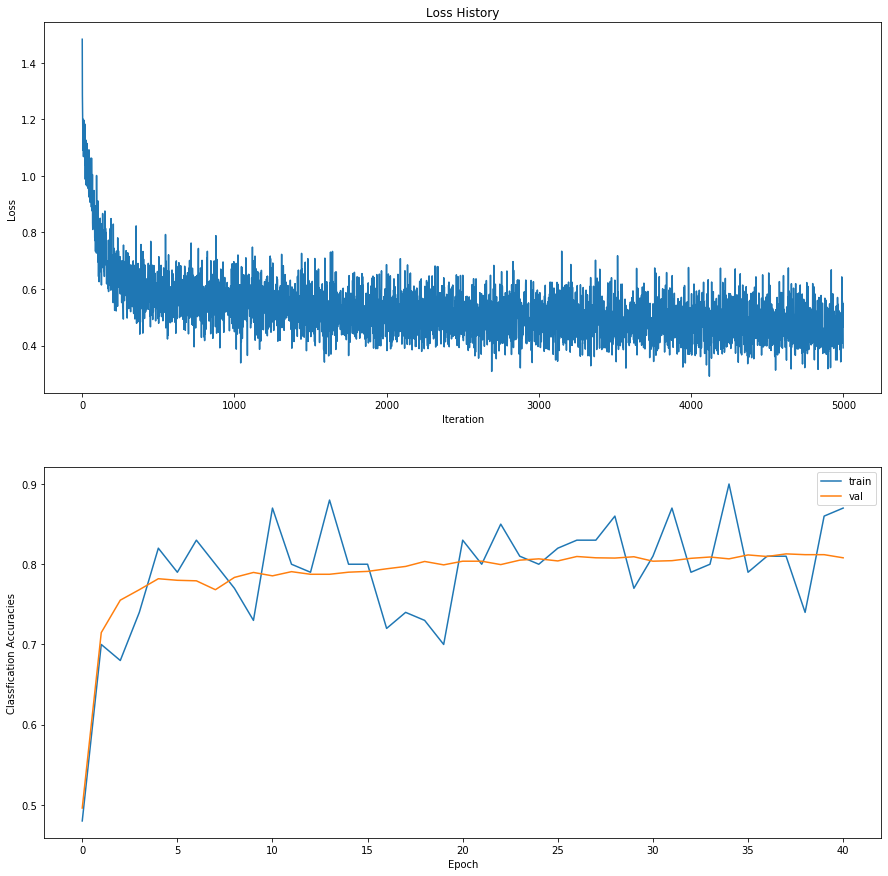

In [37]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats['train_acc_hist'], label='train')
plt.plot(stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

## Test Model

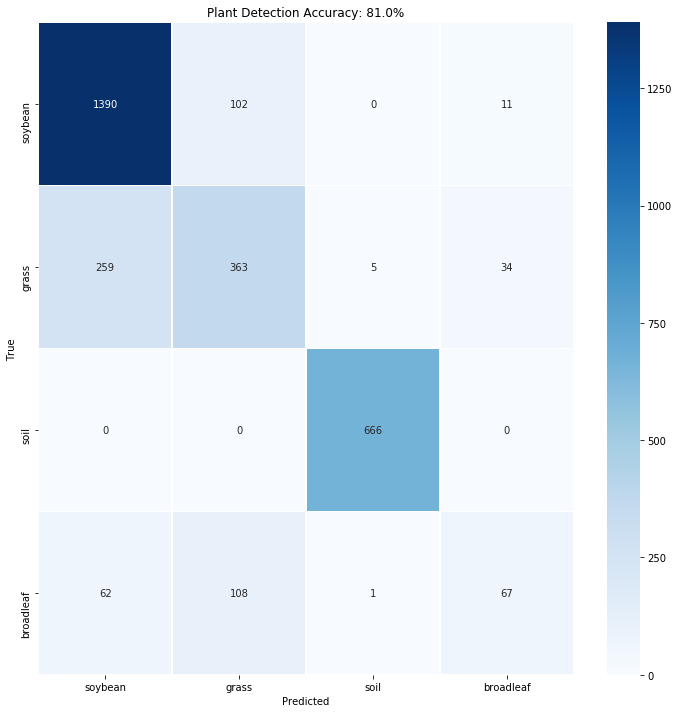

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Run predictions across the entire test set
vl_score = net.predict(X_test)

acc = accuracy_score(y_test, vl_score)*100.0
cm = confusion_matrix(y_test, vl_score)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,12))
ax = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', linewidths=.5)
ax.set_ylim(4.0, 0)
plt.title('Plant Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

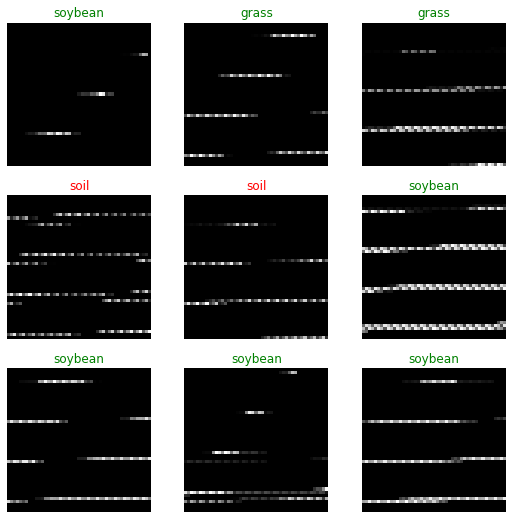

In [40]:
label_CM = {
    0: 'red',  # Incorrect classification
    1: 'green' # Correct classification
}

vl_indices = np.random.choice(len(y_test), 9)
vl_pred = []
vl_true = []

for idx in vl_indices:
    pred = net.predict(np.array([X_test[idx]]))
    vl_true.append(y_test[idx])
    vl_pred.append(pred)
vl_pred = np.array(vl_pred).flatten()

f,ax = plt.subplots(3, 3, figsize=(9, 9))
for idx in range(9):
    score = 1 if vl_pred[idx] == vl_true[idx] else 0
    class_type = classes[y_test[idx]]
    im_data = X_test[idx][0:47 * 47].reshape(47, 47)
    ax[idx//3,idx%3].imshow(im_data, cmap='gray')
    ax[idx//3,idx%3].axis('off')
    ax[idx//3,idx%3].set_title(class_type, color=label_CM[score])

## Conclusion

In this project we created a neural network from scratch using Numpy to take a datset of weed images in soybean crops and classify them into 4 classes. After 1,000 training iterations we acheived an accuracy score of 78.3%. Increasing the training iterations to 5,000 achieved a final accuracy score of 81.0% showing that more training didn't significantly improve the accuracy of the model. Most likely the class weightings were very over-weighted towards the soybean class in the dataset, leading to good accuracy on that class, but poorer accuracy on the other classes. Increasing the samples available in the other classes should solve this issue and improve the overall accuracy.

In addition, the neural net is very basic as we built it from scratch using Numpy, so a larger neural net with more layers may improve the accuracy.

## References

* https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/